# Wavelength Selection + Clustering Benchmark

This notebook systematically tests different wavelength selection configurations and evaluates clustering performance against ground truth.

## Pipeline:
1. **Load ground truth** from colored PNG annotation
2. **Generate wavelength selection configurations** (all parameter combinations)
3. **For each configuration**:
   - Run wavelength selection algorithm
   - Extract selected wavelength subset
   - Apply concatenation + KMeans clustering
   - Validate against ground truth
   - Save results
4. **Compare all configurations** and find optimal parameters
5. **Generate comprehensive analysis** of which wavelength selection approaches work best

In [1]:
# Imports and setup
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
import random
random.seed(42)
import torch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Add paths
base_dir = Path(r"C:\Users\meloy\PycharmProjects\Capstone")
sys.path.append(str(base_dir))
sys.path.append(str(base_dir / "wavelength_analysis"))

print("Environment setup completed!")
print(f"Working directory: {base_dir}")
print(f"Random seed: 42 (fixed for reproducibility)")

Environment setup completed!
Working directory: C:\Users\meloy\PycharmProjects\Capstone
Random seed: 42 (fixed for reproducibility)


In [2]:
# Import all required modules
from wavelength_analysis.core.config import AnalysisConfig
from wavelength_analysis.core.analyzer import WavelengthAnalyzer
from concatenation_clustering import (
    load_masked_data,
    concatenate_hyperspectral_data,
    perform_clustering,
    reconstruct_cluster_map
)
from ground_truth_validation import (
    extract_ground_truth_from_png,
    calculate_clustering_accuracy
)

print("All modules imported successfully!")

All modules imported successfully!


## Configuration Setup

Define all the wavelength selection configurations to test.

In [3]:
# Setup paths and basic config
sample_name = "Lichens"
data_path = base_dir / "data" / "processed" / sample_name / "lichens_data_masked.pkl"
mask_path = base_dir / "data" / "processed" / sample_name / "lichens_mask.npy"
png_path = Path(r"C:\Users\meloy\Downloads\Mask_Manual.png")
results_dir = base_dir / "wavelength_analysis" / "benchmark_results"
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Sample: {sample_name}")
print(f"Data path: {data_path}")
print(f"Mask path: {mask_path}")
print(f"PNG path: {png_path}")
print(f"Results will be saved to: {results_dir}")

Sample: Lichens
Data path: C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl
Mask path: C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy
PNG path: C:\Users\meloy\Downloads\Mask_Manual.png
Results will be saved to: C:\Users\meloy\PycharmProjects\Capstone\wavelength_analysis\benchmark_results


In [4]:
# Define comprehensive configuration matrix for benchmarking

# Parameter ranges to test
config_matrix = {
    'dimension_selection_method': ['activation', 'variance', 'pca'],
    'perturbation_method': ['percentile', 'standard_deviation', 'absolute_range'],
    'perturbation_magnitudes': [
        [5, 10, 15],
        [10, 20, 30], 
        [15, 30, 45],
        [20, 40, 60],
        [25, 50, 75]
    ],
    'n_important_dimensions': [10, 15, 20, 25, 30],
    'n_bands_to_select': [20, 25, 30, 35, 40],
    'normalization_method': ['variance', 'max_per_excitation', 'none']
}

# Generate all combinations (this will be a lot!)
from itertools import product

all_combinations = list(product(
    config_matrix['dimension_selection_method'],
    config_matrix['perturbation_method'],
    config_matrix['perturbation_magnitudes'],
    config_matrix['n_important_dimensions'],
    config_matrix['n_bands_to_select'],
    config_matrix['normalization_method']
))

print(f"Total configurations to test: {len(all_combinations)}")
print("\nFirst 5 configurations:")
for i, combo in enumerate(all_combinations[:5]):
    print(f"  {i+1}: {combo}")

# For demonstration, let's start with a smaller subset
# You can increase this number as needed
MAX_CONFIGS_TO_TEST = 50  # Adjust this based on your computational resources

if len(all_combinations) > MAX_CONFIGS_TO_TEST:
    print(f"\nLimiting to first {MAX_CONFIGS_TO_TEST} configurations for this run.")
    print("You can increase MAX_CONFIGS_TO_TEST to test more combinations.")
    selected_combinations = all_combinations[:MAX_CONFIGS_TO_TEST]
else:
    selected_combinations = all_combinations

print(f"\nWill test {len(selected_combinations)} configurations")

Total configurations to test: 3375

First 5 configurations:
  1: ('activation', 'percentile', [5, 10, 15], 10, 20, 'variance')
  2: ('activation', 'percentile', [5, 10, 15], 10, 20, 'max_per_excitation')
  3: ('activation', 'percentile', [5, 10, 15], 10, 20, 'none')
  4: ('activation', 'percentile', [5, 10, 15], 10, 25, 'variance')
  5: ('activation', 'percentile', [5, 10, 15], 10, 25, 'max_per_excitation')

Limiting to first 50 configurations for this run.
You can increase MAX_CONFIGS_TO_TEST to test more combinations.

Will test 50 configurations


## Load Ground Truth

Extract ground truth labels from the colored PNG annotation.

Extracting ground truth from PNG annotation...
Original PNG shape: (1024, 1392)
Resized to: (1040, 1392)
Found 8 unique colors in the PNG
Found 6 lichen type colors (excluding background)

Ground Truth Statistics:
  Shape: (1040, 1392)
  Number of lichen types: 6
  Type 0 (color (np.uint8(48), np.uint8(48), np.uint8(48), np.uint8(255))): 104162 pixels (7.20%)
  Type 1 (color (np.uint8(72), np.uint8(72), np.uint8(72), np.uint8(255))): 69258 pixels (4.78%)
  Type 2 (color (np.uint8(96), np.uint8(96), np.uint8(96), np.uint8(255))): 123960 pixels (8.56%)
  Type 3 (color (np.uint8(120), np.uint8(120), np.uint8(120), np.uint8(255))): 95261 pixels (6.58%)
  Type 4 (color (np.uint8(144), np.uint8(144), np.uint8(144), np.uint8(255))): 101597 pixels (7.02%)
  Type 5 (color (np.uint8(217), np.uint8(217), np.uint8(217), np.uint8(255))): 79449 pixels (5.49%)
  Background: 873993 pixels (60.37%)

✓ Found 6 lichen types in ground truth
✓ Ground truth shape: (1040, 1392)


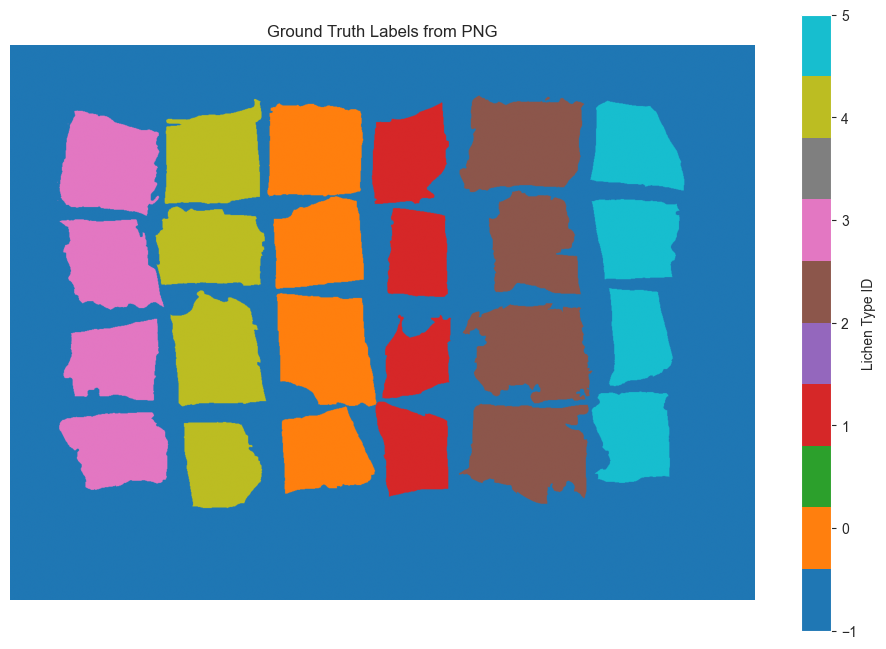

In [5]:
# Extract ground truth from PNG
print("Extracting ground truth from PNG annotation...")

background_colors = [
    (24, 24, 24, 255),      # Dark gray background
    (168, 168, 168, 255)    # Light gray background
]

ground_truth, color_mapping, lichen_colors = extract_ground_truth_from_png(
    png_path,
    background_colors=background_colors,
    target_shape=(1040, 1392)
)

n_true_classes = len(lichen_colors)
print(f"\n✓ Found {n_true_classes} lichen types in ground truth")
print(f"✓ Ground truth shape: {ground_truth.shape}")

# Visualize ground truth
plt.figure(figsize=(12, 8))
plt.imshow(ground_truth, cmap='tab10')
plt.colorbar(label='Lichen Type ID')
plt.title('Ground Truth Labels from PNG')
plt.axis('off')
plt.show()

## Load Base Data

Load the full hyperspectral dataset that will be used for wavelength selection.

In [6]:
# Load the base hyperspectral data
print("Loading base hyperspectral data...")

base_data_dict = load_masked_data(data_path)
print(f"✓ Loaded data with {len(base_data_dict['excitation_wavelengths'])} excitation wavelengths")
print(f"✓ Excitation wavelengths: {base_data_dict['excitation_wavelengths']}")

# Get data dimensions
first_ex = str(base_data_dict['excitation_wavelengths'][0])
data_shape = base_data_dict['data'][first_ex]['cube'].shape
print(f"✓ Data cube shape (first excitation): {data_shape}")

Loading base hyperspectral data...
✓ Loaded data with 8 excitation wavelengths
✓ Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
✓ Data cube shape (first excitation): (1040, 1392, 22)


## Define Benchmarking Functions

Create functions for the benchmarking pipeline.

In [ ]:
def create_config_from_params(params, base_paths):
    """
    Create AnalysisConfig from parameter tuple.
    """
    (
        dimension_selection_method,
        perturbation_method,
        perturbation_magnitudes,
        n_important_dimensions,
        n_bands_to_select,
        normalization_method
    ) = params
    
    # Create model directory if it doesn't exist
    model_dir = base_dir / "results" / f"{sample_name}_analysis" / "model"
    model_dir.mkdir(parents=True, exist_ok=True)
    
    # Try to find any existing model file, or create a path for new one
    possible_model_files = list(model_dir.glob("*.pth"))
    if possible_model_files:
        model_path = str(possible_model_files[0])
    else:
        # Path where model will be saved after training
        model_path = str(model_dir / "wavelength_selection_model.pth")
    
    return AnalysisConfig(
        sample_name=sample_name,
        data_path=str(base_paths['data_path']),
        mask_path=str(base_paths['mask_path']),
        model_path=model_path,
        dimension_selection_method=dimension_selection_method,
        perturbation_method=perturbation_method,
        perturbation_magnitudes=list(perturbation_magnitudes),
        n_important_dimensions=n_important_dimensions,
        n_bands_to_select=n_bands_to_select,
        normalization_method=normalization_method,
        output_dir="./temp_wavelength_output",  # Temporary output
        save_tiff_layers=False,  # Don't save heavy files during benchmarking
        save_visualizations=False,
        n_baseline_patches=10  # Reduce for speed
    )

def extract_selected_wavelengths_from_results(wavelength_results, base_data_dict):
    """
    Extract the data subset corresponding to selected wavelengths.
    """
    if 'selected_bands' not in wavelength_results:
        print("Warning: No selected_bands in wavelength results")
        return None
    
    selected_bands = wavelength_results['selected_bands']
    
    # Create filtered data dict
    filtered_data = {
        'data': {},
        'metadata': base_data_dict.get('metadata', {}),
        'excitation_wavelengths': base_data_dict['excitation_wavelengths'],
        'selected_bands': selected_bands
    }
    
    # Filter data based on selected bands
    for ex_str, ex_data in base_data_dict['data'].items():
        if 'wavelengths' in ex_data and 'cube' in ex_data:
            wavelengths = np.array(ex_data['wavelengths'])
            
            # Find indices of selected wavelengths
            selected_indices = []
            selected_wavelengths = []
            
            for band in selected_bands:
                # Find closest wavelength
                idx = np.argmin(np.abs(wavelengths - band))
                if idx not in selected_indices:  # Avoid duplicates
                    selected_indices.append(idx)
                    selected_wavelengths.append(wavelengths[idx])
            
            # Extract selected bands from data cube
            filtered_cube = ex_data['cube'][:, :, selected_indices]
            
            filtered_data['data'][ex_str] = {
                'cube': filtered_cube,
                'wavelengths': selected_wavelengths,
                **{k: v for k, v in ex_data.items() if k not in ['cube', 'wavelengths']}
            }
    
    return filtered_data

def run_single_benchmark(config_id, config_params, base_paths, ground_truth, n_true_classes):
    """
    Run a single benchmark configuration.
    """
    try:
        # Create configuration
        config = create_config_from_params(config_params, base_paths)
        
        print(f"Config: {config.dimension_selection_method}, {config.perturbation_method}, bands={config.n_bands_to_select}")
        
        # Step 1: Run wavelength selection
        analyzer = WavelengthAnalyzer(config)
        
        # Load data and model (will train if model doesn't exist)
        analyzer.load_data_and_model()
        
        # Run the wavelength selection analysis
        wavelength_results = analyzer.run_complete_analysis()
        
        if not wavelength_results or 'selected_bands' not in wavelength_results:
            return {
                'config_id': config_id,
                'status': 'failed',
                'error': 'Wavelength selection failed to return results',
                'config_params': config_params
            }
        
        print(f"Selected {len(wavelength_results['selected_bands'])} wavelength bands")
        
        # Step 2: Extract selected wavelength subset
        filtered_data = extract_selected_wavelengths_from_results(wavelength_results, base_data_dict)
        
        if filtered_data is None:
            return {
                'config_id': config_id,
                'status': 'failed',
                'error': 'Failed to extract selected wavelengths',
                'config_params': config_params
            }
        
        # Step 3: Run concatenation clustering on filtered data
        print("Running concatenation clustering...")
        df, valid_mask, metadata = concatenate_hyperspectral_data(
            filtered_data,
            normalize=True,
            scale=True
        )
        
        # Step 4: Perform KMeans clustering
        clustering_results = {}
        k_values_to_test = [n_true_classes-1, n_true_classes, n_true_classes+1]
        k_values_to_test = [k for k in k_values_to_test if k >= 2]  # Ensure k >= 2
        
        best_k = n_true_classes
        best_purity = 0
        
        for k in k_values_to_test:
            labels, metrics = perform_clustering(
                df,
                n_clusters=k,
                method='kmeans',
                use_pca=False,
                random_state=42  # Fixed seed
            )
            
            cluster_map = reconstruct_cluster_map(labels, df, valid_mask, metadata)
            
            # Step 5: Validate against ground truth
            gt_metrics = calculate_clustering_accuracy(cluster_map, ground_truth, valid_mask)
            
            clustering_results[f'k_{k}'] = {
                'k': k,
                'clustering_metrics': metrics,
                'ground_truth_metrics': gt_metrics
            }
            
            # Track best k based on purity
            purity = gt_metrics.get('purity', 0)
            if purity > best_purity:
                best_purity = purity
                best_k = k
        
        print(f"Best result: k={best_k}, purity={best_purity:.4f}")
        
        # Compile results
        result = {
            'config_id': config_id,
            'status': 'success',
            'config_params': {
                'dimension_selection_method': config_params[0],
                'perturbation_method': config_params[1], 
                'perturbation_magnitudes': config_params[2],
                'n_important_dimensions': config_params[3],
                'n_bands_to_select': config_params[4],
                'normalization_method': config_params[5]
            },
            'wavelength_selection': {
                'n_selected_bands': len(wavelength_results.get('selected_bands', [])),
                'selected_bands': wavelength_results.get('selected_bands', [])[:10],  # Save only first 10 for space
            },
            'concatenated_data': {
                'n_pixels': df.shape[0],
                'n_features': df.shape[1] - 2,  # Exclude x, y
            },
            'clustering_results': clustering_results,
            'best_k': best_k,
            'best_purity': best_purity,
            'summary_metrics': clustering_results[f'k_{best_k}']['ground_truth_metrics']
        }
        
        return result
        
    except Exception as e:
        import traceback
        error_details = f"{str(e)}\\n{traceback.format_exc()}"
        print(f"ERROR in {config_id}: {str(e)}")
        
        return {
            'config_id': config_id,
            'status': 'error',
            'error': str(e),
            'error_details': error_details,
            'config_params': config_params
        }

print("Fixed benchmarking functions defined!")"

## Run Benchmarking

Execute the systematic benchmarking across all configurations.

In [ ]:
# Setup for benchmarking
base_paths = {
    'data_path': data_path,
    'mask_path': mask_path
}

# Initialize results storage
all_results = []
successful_results = []
failed_results = []

print(f"Starting benchmarking of {len(selected_combinations)} configurations...")
print(f"Results will be saved incrementally to avoid data loss.")

# Run benchmarking with progress tracking
for i, config_params in enumerate(tqdm(selected_combinations, desc="Benchmarking configs")):
    config_id = f"config_{i:03d}"
    
    print(f"\n{'='*60}")
    print(f"Running {config_id} ({i+1}/{len(selected_combinations)})")
    print(f"Parameters: {config_params}")
    print('='*60)
    
    # Run single benchmark
    result = run_single_benchmark(
        config_id, 
        config_params, 
        base_paths, 
        ground_truth, 
        n_true_classes
    )
    
    # Store result
    all_results.append(result)
    
    if result['status'] == 'success':
        successful_results.append(result)
        print(f"✓ SUCCESS - Best purity: {result['best_purity']:.4f} (k={result['best_k']})")
    else:
        failed_results.append(result)
        print(f"✗ FAILED - Error: {result.get('error', 'Unknown error')}")
    
    # Save results incrementally every 5 configs
    if (i + 1) % 5 == 0 or (i + 1) == len(selected_combinations):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        temp_results_file = results_dir / f"benchmark_results_partial_{timestamp}.pkl"
        
        with open(temp_results_file, 'wb') as f:
            pickle.dump({
                'all_results': all_results,
                'successful_results': successful_results,
                'failed_results': failed_results,
                'n_completed': i + 1,
                'n_total': len(selected_combinations),
                'ground_truth_info': {
                    'n_classes': n_true_classes,
                    'shape': ground_truth.shape
                }
            }, f)
        
        print(f"\n📁 Saved partial results to {temp_results_file}")
        print(f"Progress: {len(successful_results)} successful, {len(failed_results)} failed")

print(f"\n{'='*80}")
print("BENCHMARKING COMPLETED!")
print(f"Total configurations tested: {len(all_results)}")
print(f"Successful: {len(successful_results)}")
print(f"Failed: {len(failed_results)}")
print('='*80)

Starting benchmarking of 50 configurations...
Results will be saved incrementally to avoid data loss.


Benchmarking configs:   0%|          | 0/50 [00:00<?, ?it/s]


Running config_000 (1/50)
Parameters: ('activation', 'percentile', [5, 10, 15], 10, 20, 'variance')
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: temp_wavelength_output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 nm: 22 bands
  - Excitation 340.0 nm: 22 bands
  - Excitation 365.0 nm: 27 bands
  - Excitation 385.0 nm: 28 bands
  - Excitation 400.0 nm: 25 bands
  - Excitati

Benchmarking configs:   2%|▏         | 1/50 [00:10<08:57, 10.96s/it]

✗ FAILED - Error: [Errno 2] No such file or directory: 'C:\\Users\\meloy\\PycharmProjects\\Capstone\\results\\Lichens_analysis\\model\\best_hyperspectral_model.pth'

Running config_001 (2/50)
Parameters: ('activation', 'percentile', [5, 10, 15], 10, 20, 'max_per_excitation')
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: temp_wavelength_output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Exc

Benchmarking configs:   4%|▍         | 2/50 [00:21<08:35, 10.73s/it]

✗ FAILED - Error: [Errno 2] No such file or directory: 'C:\\Users\\meloy\\PycharmProjects\\Capstone\\results\\Lichens_analysis\\model\\best_hyperspectral_model.pth'

Running config_002 (3/50)
Parameters: ('activation', 'percentile', [5, 10, 15], 10, 20, 'none')
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: temp_wavelength_output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 325.0 

Benchmarking configs:   6%|▌         | 3/50 [00:32<08:30, 10.87s/it]

✗ FAILED - Error: [Errno 2] No such file or directory: 'C:\\Users\\meloy\\PycharmProjects\\Capstone\\results\\Lichens_analysis\\model\\best_hyperspectral_model.pth'

Running config_003 (4/50)
Parameters: ('activation', 'percentile', [5, 10, 15], 10, 25, 'variance')
Wavelength Analyzer initialized for Lichens
Using device: cuda
Output directory: temp_wavelength_output

Loading data and model...
Loading data from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_data_masked.pkl...
Data Summary:
Number of excitation wavelengths: 8
Excitation wavelengths: [310.0, 325.0, 340.0, 365.0, 385.0, 400.0, 415.0, 430.0]
Data shape for first excitation (310.0 nm): (1040, 1392, 22)
Loading mask from C:\Users\meloy\PycharmProjects\Capstone\data\processed\Lichens\lichens_mask.npy...
Mask loaded: 573687/1447680 valid pixels (39.63%)
Preparing data for 8 excitation wavelengths...
Emission band lengths for each excitation wavelength:
  - Excitation 310.0 nm: 22 bands
  - Excitation 32

## Save Final Results

Save all results with comprehensive metadata.

In [ ]:
# Save comprehensive final results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
final_results_file = results_dir / f"wavelength_benchmark_final_{timestamp}.pkl"
final_summary_file = results_dir / f"wavelength_benchmark_summary_{timestamp}.json"

# Prepare final results package
final_results = {
    'metadata': {
        'timestamp': timestamp,
        'sample_name': sample_name,
        'data_path': str(data_path),
        'ground_truth_path': str(png_path),
        'n_true_classes': n_true_classes,
        'ground_truth_shape': ground_truth.shape,
        'total_configs_tested': len(all_results),
        'successful_configs': len(successful_results),
        'failed_configs': len(failed_results),
        'random_seed': 42
    },
    'configuration_matrix': config_matrix,
    'all_results': all_results,
    'successful_results': successful_results,
    'failed_results': failed_results,
    'ground_truth': ground_truth,
    'color_mapping': color_mapping
}

# Save pickle file (comprehensive)
with open(final_results_file, 'wb') as f:
    pickle.dump(final_results, f)

print(f"✓ Saved comprehensive results to: {final_results_file}")

# Create summary for quick analysis
if successful_results:
    best_result = max(successful_results, key=lambda x: x['best_purity'])
    
    summary = {
        'experiment_info': final_results['metadata'],
        'best_configuration': {
            'config_id': best_result['config_id'],
            'parameters': best_result['config_params'],
            'best_purity': best_result['best_purity'],
            'best_k': best_result['best_k'],
            'summary_metrics': best_result['summary_metrics']
        },
        'top_5_configurations': [
            {
                'config_id': r['config_id'],
                'parameters': r['config_params'], 
                'purity': r['best_purity'],
                'k': r['best_k']
            }
            for r in sorted(successful_results, key=lambda x: x['best_purity'], reverse=True)[:5]
        ],
        'statistics': {
            'mean_purity': np.mean([r['best_purity'] for r in successful_results]),
            'std_purity': np.std([r['best_purity'] for r in successful_results]),
            'max_purity': max(r['best_purity'] for r in successful_results),
            'min_purity': min(r['best_purity'] for r in successful_results)
        }
    }
else:
    summary = {
        'experiment_info': final_results['metadata'],
        'note': 'No successful configurations found',
        'failed_configs': len(failed_results)
    }

# Save JSON summary (human readable)
with open(final_summary_file, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"✓ Saved summary to: {final_summary_file}")

if successful_results:
    print(f"\n📊 BEST CONFIGURATION FOUND:")
    print(f"   Config ID: {best_result['config_id']}")
    print(f"   Purity Score: {best_result['best_purity']:.4f}")
    print(f"   Optimal K: {best_result['best_k']}")
    print(f"   Parameters: {best_result['config_params']}")

## Results Analysis

Analyze and visualize the benchmarking results.

In [ ]:
# Analysis of results
if not successful_results:
    print("No successful results to analyze. Check the failed results for issues.")
    if failed_results:
        print("\nFailed results summary:")
        for result in failed_results:
            print(f"  {result['config_id']}: {result['error']}")
else:
    print(f"Analyzing {len(successful_results)} successful configurations...")
    
    # Create analysis DataFrame
    analysis_data = []
    for result in successful_results:
        params = result['config_params']
        metrics = result['summary_metrics']
        
        analysis_data.append({
            'config_id': result['config_id'],
            'dimension_selection_method': params['dimension_selection_method'],
            'perturbation_method': params['perturbation_method'],
            'n_important_dimensions': params['n_important_dimensions'],
            'n_bands_to_select': params['n_bands_to_select'],
            'normalization_method': params['normalization_method'],
            'purity': result['best_purity'],
            'best_k': result['best_k'],
            'ari': metrics.get('adjusted_rand_score', 0),
            'nmi': metrics.get('normalized_mutual_info', 0),
            'v_measure': metrics.get('v_measure', 0),
            'homogeneity': metrics.get('homogeneity', 0),
            'completeness': metrics.get('completeness', 0),
            'n_features': result['concatenated_data']['n_features']
        })
    
    df_analysis = pd.DataFrame(analysis_data)
    
    # Save analysis DataFrame
    analysis_csv_file = results_dir / f"wavelength_benchmark_analysis_{timestamp}.csv"
    df_analysis.to_csv(analysis_csv_file, index=False)
    print(f"✓ Saved analysis DataFrame to: {analysis_csv_file}")
    
    # Display top results
    print("\n📈 TOP 10 CONFIGURATIONS BY PURITY:")
    top_10 = df_analysis.nlargest(10, 'purity')
    print(top_10[['config_id', 'dimension_selection_method', 'perturbation_method', 
                  'n_bands_to_select', 'purity', 'ari', 'nmi']].to_string(index=False))
    
    # Show statistics by parameter
    print("\n📊 AVERAGE PURITY BY PARAMETER:")
    categorical_params = ['dimension_selection_method', 'perturbation_method', 'normalization_method']
    
    for param in categorical_params:
        param_stats = df_analysis.groupby(param)['purity'].agg(['mean', 'std', 'count']).round(4)
        print(f"\n{param}:")
        print(param_stats.to_string())
    
    print("\nAnalysis completed!")

In [ ]:
# Create visualizations
if successful_results and len(successful_results) > 1:
    
    # 1. Purity distribution
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Purity histogram
    plt.subplot(2, 3, 1)
    plt.hist(df_analysis['purity'], bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Purity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Purity Scores')
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Purity by dimension selection method
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df_analysis, x='dimension_selection_method', y='purity')
    plt.title('Purity by Dimension Selection Method')
    plt.xticks(rotation=45)
    
    # Subplot 3: Purity by perturbation method
    plt.subplot(2, 3, 3)
    sns.boxplot(data=df_analysis, x='perturbation_method', y='purity')
    plt.title('Purity by Perturbation Method')
    plt.xticks(rotation=45)
    
    # Subplot 4: Purity vs number of bands
    plt.subplot(2, 3, 4)
    plt.scatter(df_analysis['n_bands_to_select'], df_analysis['purity'], alpha=0.6)
    plt.xlabel('Number of Bands Selected')
    plt.ylabel('Purity Score')
    plt.title('Purity vs Number of Selected Bands')
    plt.grid(True, alpha=0.3)
    
    # Subplot 5: Purity vs important dimensions
    plt.subplot(2, 3, 5)
    plt.scatter(df_analysis['n_important_dimensions'], df_analysis['purity'], alpha=0.6)
    plt.xlabel('Number of Important Dimensions')
    plt.ylabel('Purity Score')
    plt.title('Purity vs Important Dimensions')
    plt.grid(True, alpha=0.3)
    
    # Subplot 6: Correlation heatmap of metrics
    plt.subplot(2, 3, 6)
    metric_cols = ['purity', 'ari', 'nmi', 'v_measure', 'homogeneity', 'completeness']
    correlation_matrix = df_analysis[metric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('Metric Correlations')
    
    plt.tight_layout()
    
    # Save visualization
    viz_file = results_dir / f"wavelength_benchmark_visualization_{timestamp}.png"
    plt.savefig(viz_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved visualization to: {viz_file}")
    
    # Additional analysis: Feature importance
    print("\n🔍 PARAMETER IMPORTANCE ANALYSIS:")
    
    # Calculate average purity improvement for each parameter value
    baseline_purity = df_analysis['purity'].mean()
    
    for param in categorical_params:
        param_means = df_analysis.groupby(param)['purity'].mean()
        improvements = param_means - baseline_purity
        
        print(f"\n{param} (baseline: {baseline_purity:.4f}):")
        for value, improvement in improvements.items():
            sign = "+" if improvement >= 0 else ""
            print(f"  {value}: {sign}{improvement:.4f} ({param_means[value]:.4f})")

print("\n🎉 BENCHMARKING COMPLETE!")
print(f"📂 All results saved in: {results_dir}")
print(f"📊 Check the CSV file for detailed analysis")
print(f"📈 Check the visualization for parameter comparisons")